In [48]:
import pandas as pd
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from termcolor import colored
import ast
pd.set_option('display.max_columns', None)

# Data loading

In [3]:
data_path = Path().absolute().parent/'data'
geo_info = pd.read_csv(data_path/'geo_info.csv', sep=';')
referer_vectors = pd.read_csv(data_path/'referer_vectors.csv', sep=';')
test = pd.read_csv(data_path/'test.csv', sep=';')
test_users = pd.read_csv(data_path/'test_users.csv', sep=';')
train = pd.read_csv(data_path/'train.csv', sep=';')
train_labels = pd.read_csv(data_path/'train_labels.csv', sep=';')

# Initial analysis

In [5]:
train.info()
display(train.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   request_ts  750000 non-null  int64 
 1   user_id     750000 non-null  object
 2   referer     750000 non-null  object
 3   geo_id      750000 non-null  int64 
 4   user_agent  749999 non-null  object
dtypes: int64(2), object(3)
memory usage: 28.6+ MB


,request_ts,user_id,referer,geo_id,user_agent
23377,1700971638,5bbc4e11a38df9f930f53b8555f628f9,https://6c16abb/,4106,"{'browser': 'Chrome Mobile', 'browser_version'..."
618851,1701021574,99ebc50d194b0171856f8a3989c34b17,https://6a81948/1352064b,2740,"{'browser': 'YandexSearch', 'browser_version':..."
256424,1701028369,287998cf70cafc059ce82a592c55f989,https://8807153/,3663,"{'browser': 'Yandex Browser', 'browser_version..."
635185,1700973333,375438cba012cef31054434ee95618bd,https://8d946e9/,3663,"{'browser': 'Yandex Browser', 'browser_version..."
235827,1700992309,45faeb27888cb98602ca41edda867278,https://6a81948/,3663,"{'browser': 'YandexSearch', 'browser_version':..."


In [6]:
geo_info.info()
display(geo_info.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   geo_id       5533 non-null   int64 
 1   country_id   5533 non-null   object
 2   region_id    3826 non-null   object
 3   timezone_id  5533 non-null   object
dtypes: int64(1), object(3)
memory usage: 173.0+ KB


,geo_id,country_id,region_id,timezone_id
333,8864,c31b4e,978f9b,e56e80
4219,7928,c31b4e,895e40,109a080
4848,8851,c31b4e,23f9c2,f6155e
952,4099,1234f1d,3fddc5,1054b86
894,7357,c31b4e,393070,caf0e9


In [7]:
referer_vectors.info()
display(referer_vectors.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   component0  200000 non-null  int64 
 1   component1  200000 non-null  int64 
 2   component2  200000 non-null  int64 
 3   component3  200000 non-null  int64 
 4   component4  200000 non-null  int64 
 5   component5  200000 non-null  int64 
 6   component6  200000 non-null  int64 
 7   component7  200000 non-null  int64 
 8   component8  200000 non-null  int64 
 9   component9  200000 non-null  int64 
 10  referer     200000 non-null  object
dtypes: int64(10), object(1)
memory usage: 16.8+ MB


,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,referer
122090,3178,-8881,-15601,-771,22672,-7482,5048,-2905,16708,483,https://9ac1e4f/14c7b880
50977,15887,3820,12247,-5923,7846,4117,-4582,7102,1027,21651,https://8406d63/1367e2b9
117277,16623,14986,9767,4100,9178,9722,5279,-90,11836,6096,https://7e89575/12ff734c
24968,20673,6821,8968,-4219,-2059,9300,1670,1823,2425,19771,https://9c23da0/134134cd
138235,14606,5272,14823,9692,11690,2922,8469,8414,6190,-13170,https://8406d63/17cd46c8


In [8]:
train_labels.info()
display(train_labels.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  500000 non-null  object
 1   target   500000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


,user_id,target
279436,adfe7822d0507448791a9b020e480ac5,1
266466,4098c0a6abf3e2c0e4b5da6e18d209a3,0
332792,a7fb9f7c1c9bb5e6dbab1f5f27150d28,0
99250,7fc28092b0a0c7ceaeda0ea1447ee63e,0
462302,af9be8685f9f3227e4339387c8737005,1


# Data Processing

In [9]:
# Объединим таблицы
train = pd.merge(train, geo_info, on='geo_id')
train = pd.merge(train, referer_vectors, on='referer')
train = pd.merge(train, train_labels, on='user_id')
train = train.drop(['geo_id', 'referer'], axis=1)

In [10]:
# Найдем и удалим дубликаты
print('Количество дубликатов:', train.duplicated().sum())
train = train.drop_duplicates()

Количество дубликатов: 9454


In [11]:
# Найдем и удалим пропуски
print('Кол-во пропусков:\n', train.isnull().sum())
train = train.dropna(axis=0, how='any')

Кол-во пропусков:
 request_ts         0
user_id            0
user_agent         1
country_id         0
region_id      49903
timezone_id        0
component0         0
component1         0
component2         0
component3         0
component4         0
component5         0
component6         0
component7         0
component8         0
component9         0
target             0
dtype: int64


In [12]:
train[(train['country_id']=='c31b4e') & (train['timezone_id']=='e56e80')].head(3)

,request_ts,user_id,user_agent,country_id,region_id,timezone_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,target
1,1700986581,46a5f128fd569c764a92c2eaa788095e,"{'browser': 'Chrome Mobile', 'browser_version'...",c31b4e,44520b,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,0
3,1700992803,af735816ca19115431ae3d89518c8c91,"{'browser': 'Chrome Mobile', 'browser_version'...",c31b4e,3c9dca,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,0
5,1700956244,b74aaac38e44f90517d3e217fa118cec,"{'browser': 'Chrome Mobile', 'browser_version'...",c31b4e,1fbfa5,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,0


In [13]:
train[(train['region_id']=='3c9dca')].head(3)

,request_ts,user_id,user_agent,country_id,region_id,timezone_id,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,target
3,1700992803,af735816ca19115431ae3d89518c8c91,"{'browser': 'Chrome Mobile', 'browser_version'...",c31b4e,3c9dca,e56e80,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,0
804,1701023748,5b3cdd0eba30838fb01deb702845cdf4,"{'browser': 'Chrome Mobile', 'browser_version'...",c31b4e,3c9dca,e56e80,13294,3884,10452,-1916,11369,6138,-2472,10123,3029,21118,1
1024,1701019068,18232c8806188f0adeb265e4600223af,"{'browser': 'Chrome', 'browser_version': '118....",c31b4e,3c9dca,e56e80,16220,2266,9404,-3442,11485,4129,-3919,6506,2556,21868,0


In [14]:
train = train.drop(['country_id', 'timezone_id'], axis=1)

Признаки country_id и timezone_id не информативны, поскольку при их фиксированных значениях параметр region_id имеет различные значения. А фиксированному region_id соответствуют одни и те же единственные показатели country_id и timezone_id. Поэтому мы можем исключить эти столбцы.

In [16]:
# Раскроем словарь столбца user_agent
list = ['browser', 'browser_version', 'os', 'os_version']
for key in list:
    train[key] = train['user_agent'].apply(lambda x: ast.literal_eval(x)[key])
train = train.drop('user_agent', axis=1)

In [19]:
# Ввиду высокой смысловой корреляции между browser и os,удаляем последний, тк он, к тому же, менее информативен
train = train.drop(['os', 'browser_version', 'os_version'], axis=1)

In [20]:
train = train.drop(['user_id'], axis=1)

In [21]:
# выделим топ 25 значений столбца browser
top_25 = [x for x in train['browser'].value_counts().sort_values(ascending=False).head(25).index]
train['browser'] = train['browser'].apply(lambda x: x if x in top_25 else 'Other')

In [22]:
# преобразуем столбец дата-время request_ts
train['request_date'] = pd.to_datetime(train['request_ts'], unit='s')
train.insert(loc=1,column='request_year', value=train['request_date'].dt.year)
train.insert(loc=2, column='request_month', value=train['request_date'].dt.month)
train.insert(loc=3, column='request_dayofweek', value=(train['request_date'].dt.dayofweek)+1)
train.insert(loc=4, column='request_hour', value=train['request_date'].dt.hour)

print('Number of unique year: ', train['request_year'].nunique())
print('Number of unique month: ', train['request_month'].nunique())
print('Number of unique dayofweek: ', train['request_dayofweek'].nunique())
print('\n',train['request_dayofweek'].value_counts())
print('\nNumber of unique hour: ', train['request_hour'].nunique())

# Удалим стоблцы year, month, тк они не информативны и содержат единственное значение. Столбец request_dayofweek, поскольку он содержит только дни 6 и 7, которые коррелируют как выходные. А также исходный request_ts и request_date
train = train.drop(['request_year', 'request_month', 'request_ts', 'request_dayofweek', 'request_date'], axis=1)

Number of unique year:  1
Number of unique month:  1
Number of unique dayofweek:  2

 request_dayofweek
7    510348
6     31584
Name: count, dtype: int64

Number of unique hour:  24


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541932 entries, 0 to 601289
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   request_hour  541932 non-null  int32 
 1   region_id     541932 non-null  object
 2   component0    541932 non-null  int64 
 3   component1    541932 non-null  int64 
 4   component2    541932 non-null  int64 
 5   component3    541932 non-null  int64 
 6   component4    541932 non-null  int64 
 7   component5    541932 non-null  int64 
 8   component6    541932 non-null  int64 
 9   component7    541932 non-null  int64 
 10  component8    541932 non-null  int64 
 11  component9    541932 non-null  int64 
 12  target        541932 non-null  int64 
 13  browser       541932 non-null  object
dtypes: int32(1), int64(11), object(2)
memory usage: 60.0+ MB


Построим тепловую карту и корреляционную матрицу признаков:

<Axes: >

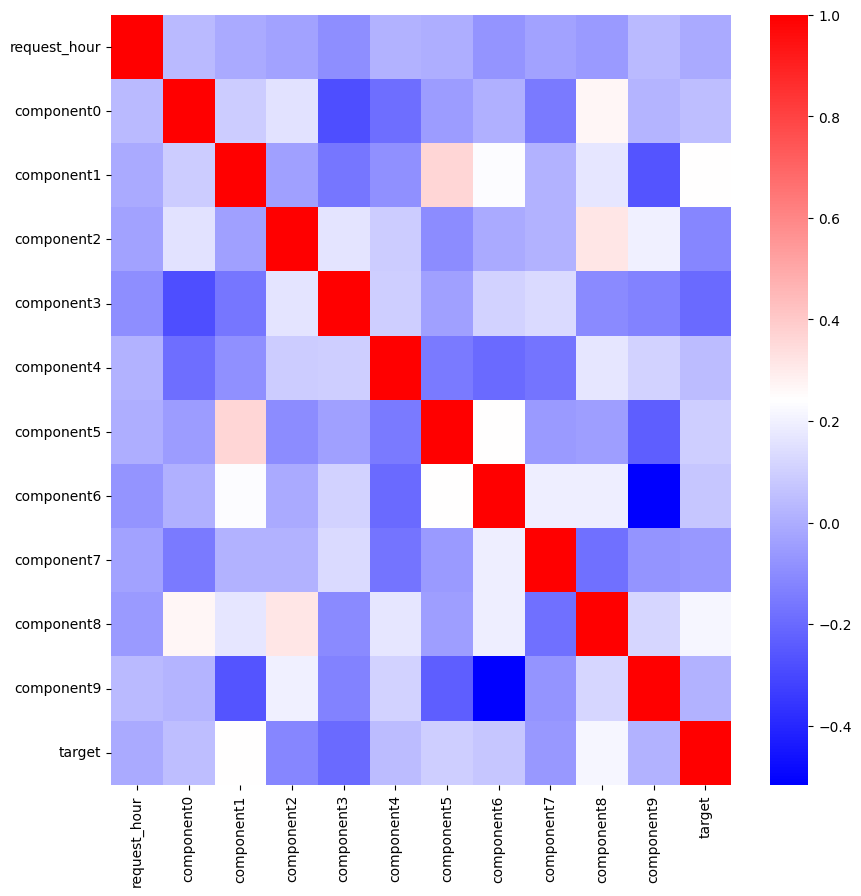

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.drop(['region_id', 'browser'], axis = 1).corr(), cmap = 'bwr')

In [34]:
train.drop(['region_id', 'browser'], axis = 1).corr()['target'].sort_values(ascending = False)

target          1.000000
component1      0.247153
component8      0.214050
component5      0.097713
component6      0.070640
component0      0.050838
component4      0.045475
component9      0.012024
request_hour   -0.006845
component7     -0.063404
component2     -0.116271
component3     -0.197629
Name: target, dtype: float64

Обратим внимание, что в датасете нет коррелирующих с целевой переменной признаков.  
Также можно выделить признаки 'component9', 'request_hour' с корреляцией около нуля, которые в модели можно не учитывать.

In [35]:
# нормализуем столбцы
numeric_features = ['component0', 'component1', 'component2', 'component3', 'component4', 'component5', \
                    'component6', 'component7', 'component8', 'component9']
time_feature = ['request_hour']
mean_encoding_feature = ['region_id']


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)

target = TargetEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', one_hot_encoder, ['browser']),
        ("hour_sin", sin_transformer(24), ["request_hour"]),
        ("hour_cos", cos_transformer(24), ["request_hour"]),
        ('trgt', target, ['region_id'])
    ])

preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['component0', 'component1', 'component2',
                                  'component3', 'component4', 'component5',
                                  'component6', 'component7', 'component8',
                                  'component9']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['browser']),
                                ('hour_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x0000024AE1F644A0>),
                                 ['request_hour']),
                                ('hour_cos',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0000024AE1F64540>),
                                 ['request_hour']),
                                ('trgt', TargetEncoder(), ['region_id'])])

In [50]:
# определим целевую переменную и обучающий набор
X = train.drop('target', axis=1)
y = train['target']

In [51]:
df_pandas = preprocessor.fit_transform(X, y)

# Model for predicting gender

In [60]:
# Создадим списки для хранения метрик
train_accuracies = []
test_accuracies = []
training_times = []

#Для кросс-валидации определим число фолодов:
kf = KFold(n_splits = 5)
i = 1
# Обучим модель
for train_index, test_index in kf.split(df_pandas):
    print(f'Фолд №  {i}')
    X_train = df_pandas.iloc[train_index]
    X_test = df_pandas.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    start_time = time.time()
    for n_estimators in tqdm(range(1, 26), desc="Обучение модели"):
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Засекаем время обучения
        estimator_start_time = time.time()
        model.fit(X_train, y_train)
        estimator_time = time.time() - estimator_start_time
    
    # Оценка точности на обучающей и тестовой выборках
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, model.predict(X_test))

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        training_times.append(estimator_time)

        # Вывод информации о прогрессе
        elapsed_time = time.time() - start_time
        print(f'Эпоха {n_estimators:<3}/100 - Время: {elapsed_time:.2f} секунд - '
          f'Точность на обучающей выборке: {train_accuracy:.4f} - '
          f'Точность на тестовой выборке: {test_accuracy:.4f}')
    i += 1

Фолд №  1


Обучение модели:   4%|▍         | 1/25 [00:02<01:01,  2.56s/it]

Эпоха 1  /100 - Время: 2.57 секунд - Точность на обучающей выборке: 0.8954 - Точность на тестовой выборке: 0.7448


Обучение модели:   8%|▊         | 2/25 [00:07<01:25,  3.72s/it]

Эпоха 2  /100 - Время: 7.09 секунд - Точность на обучающей выборке: 0.8970 - Точность на тестовой выборке: 0.7494


Обучение модели:  12%|█▏        | 3/25 [00:13<01:49,  4.96s/it]

Эпоха 3  /100 - Время: 13.54 секунд - Точность на обучающей выборке: 0.9378 - Точность на тестовой выборке: 0.7713


Обучение модели:  16%|█▌        | 4/25 [00:22<02:20,  6.70s/it]

Эпоха 4  /100 - Время: 22.91 секунд - Точность на обучающей выборке: 0.9385 - Точность на тестовой выборке: 0.7733


Обучение модели:  20%|██        | 5/25 [00:34<02:50,  8.54s/it]

Эпоха 5  /100 - Время: 34.70 секунд - Точность на обучающей выборке: 0.9530 - Точность на тестовой выборке: 0.7822


Обучение модели:  24%|██▍       | 6/25 [00:47<03:11, 10.07s/it]

Эпоха 6  /100 - Время: 47.74 секунд - Точность на обучающей выборке: 0.9535 - Точность на тестовой выборке: 0.7825


Обучение модели:  28%|██▊       | 7/25 [01:03<03:35, 11.98s/it]

Эпоха 7  /100 - Время: 63.65 секунд - Точность на обучающей выборке: 0.9611 - Точность на тестовой выборке: 0.7872


Обучение модели:  32%|███▏      | 8/25 [01:21<03:57, 13.95s/it]

Эпоха 8  /100 - Время: 81.81 секунд - Точность на обучающей выборке: 0.9612 - Точность на тестовой выборке: 0.7876


Обучение модели:  36%|███▌      | 9/25 [01:41<04:10, 15.63s/it]

Эпоха 9  /100 - Время: 101.14 секунд - Точность на обучающей выборке: 0.9657 - Точность на тестовой выборке: 0.7907


Обучение модели:  40%|████      | 10/25 [02:02<04:22, 17.53s/it]

Эпоха 10 /100 - Время: 122.91 секунд - Точность на обучающей выборке: 0.9657 - Точность на тестовой выборке: 0.7905


Обучение модели:  44%|████▍     | 11/25 [02:32<04:57, 21.27s/it]

Эпоха 11 /100 - Время: 152.67 секунд - Точность на обучающей выборке: 0.9689 - Точность на тестовой выборке: 0.7933


Обучение модели:  48%|████▊     | 12/25 [02:58<04:54, 22.68s/it]

Эпоха 12 /100 - Время: 178.57 секунд - Точность на обучающей выборке: 0.9689 - Точность на тестовой выборке: 0.7935


Обучение модели:  52%|█████▏    | 13/25 [03:24<04:44, 23.75s/it]

Эпоха 13 /100 - Время: 204.78 секунд - Точность на обучающей выборке: 0.9711 - Точность на тестовой выборке: 0.7951


Обучение модели:  56%|█████▌    | 14/25 [03:53<04:36, 25.16s/it]

Эпоха 14 /100 - Время: 233.20 секунд - Точность на обучающей выборке: 0.9710 - Точность на тестовой выборке: 0.7955


Обучение модели:  60%|██████    | 15/25 [04:24<04:29, 26.99s/it]

Эпоха 15 /100 - Время: 264.43 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7967


Обучение модели:  64%|██████▍   | 16/25 [04:59<04:24, 29.36s/it]

Эпоха 16 /100 - Время: 299.30 секунд - Точность на обучающей выборке: 0.9726 - Точность на тестовой выборке: 0.7969


Обучение модели:  68%|██████▊   | 17/25 [05:35<04:11, 31.40s/it]

Эпоха 17 /100 - Время: 335.43 секунд - Точность на обучающей выборке: 0.9739 - Точность на тестовой выборке: 0.7975


Обучение модели:  72%|███████▏  | 18/25 [06:16<03:59, 34.22s/it]

Эпоха 18 /100 - Время: 376.22 секунд - Точность на обучающей выборке: 0.9738 - Точность на тестовой выборке: 0.7979


Обучение модели:  76%|███████▌  | 19/25 [06:59<03:42, 37.07s/it]

Эпоха 19 /100 - Время: 419.93 секунд - Точность на обучающей выборке: 0.9749 - Точность на тестовой выборке: 0.7986


Обучение модели:  80%|████████  | 20/25 [07:45<03:17, 39.48s/it]

Эпоха 20 /100 - Время: 465.03 секунд - Точность на обучающей выборке: 0.9749 - Точность на тестовой выборке: 0.7987


Обучение модели:  84%|████████▍ | 21/25 [08:34<02:49, 42.36s/it]

Эпоха 21 /100 - Время: 514.11 секунд - Точность на обучающей выборке: 0.9756 - Точность на тестовой выборке: 0.7992


Обучение модели:  88%|████████▊ | 22/25 [09:24<02:14, 44.70s/it]

Эпоха 22 /100 - Время: 564.27 секунд - Точность на обучающей выборке: 0.9755 - Точность на тестовой выборке: 0.7991


Обучение модели:  92%|█████████▏| 23/25 [10:16<01:34, 47.03s/it]

Эпоха 23 /100 - Время: 616.74 секунд - Точность на обучающей выборке: 0.9763 - Точность на тестовой выборке: 0.8004


Обучение модели:  96%|█████████▌| 24/25 [11:07<00:48, 48.13s/it]

Эпоха 24 /100 - Время: 667.42 секунд - Точность на обучающей выборке: 0.9762 - Точность на тестовой выборке: 0.7998


Обучение модели: 100%|██████████| 25/25 [11:58<00:00, 28.73s/it]


Эпоха 25 /100 - Время: 718.30 секунд - Точность на обучающей выборке: 0.9768 - Точность на тестовой выборке: 0.8004
Фолд №  26


Обучение модели:   4%|▍         | 1/25 [00:02<01:00,  2.51s/it]

Эпоха 1  /100 - Время: 2.51 секунд - Точность на обучающей выборке: 0.8957 - Точность на тестовой выборке: 0.7459


Обучение модели:   8%|▊         | 2/25 [00:07<01:27,  3.82s/it]

Эпоха 2  /100 - Время: 7.24 секунд - Точность на обучающей выборке: 0.8975 - Точность на тестовой выборке: 0.7489


Обучение модели:  12%|█▏        | 3/25 [00:13<01:52,  5.10s/it]

Эпоха 3  /100 - Время: 13.88 секунд - Точность на обучающей выборке: 0.9385 - Точность на тестовой выборке: 0.7732


Обучение модели:  16%|█▌        | 4/25 [00:22<02:17,  6.57s/it]

Эпоха 4  /100 - Время: 22.69 секунд - Точность на обучающей выборке: 0.9385 - Точность на тестовой выборке: 0.7727


Обучение модели:  20%|██        | 5/25 [00:33<02:42,  8.11s/it]

Эпоха 5  /100 - Время: 33.55 секунд - Точность на обучающей выборке: 0.9531 - Точность на тестовой выборке: 0.7816


Обучение модели:  24%|██▍       | 6/25 [00:46<03:04,  9.69s/it]

Эпоха 6  /100 - Время: 46.29 секунд - Точность на обучающей выборке: 0.9536 - Точность на тестовой выборке: 0.7822


Обучение модели:  28%|██▊       | 7/25 [01:00<03:23, 11.33s/it]

Эпоха 7  /100 - Время: 60.99 секунд - Точность на обучающей выборке: 0.9612 - Точность на тестовой выборке: 0.7869


Обучение модели:  32%|███▏      | 8/25 [01:18<03:43, 13.17s/it]

Эпоха 8  /100 - Время: 78.10 секунд - Точность на обучающей выборке: 0.9613 - Точность на тестовой выборке: 0.7873


Обучение модели:  36%|███▌      | 9/25 [01:37<04:00, 15.04s/it]

Эпоха 9  /100 - Время: 97.24 секунд - Точность на обучающей выборке: 0.9659 - Точность на тестовой выборке: 0.7904


Обучение модели:  40%|████      | 10/25 [01:58<04:14, 16.94s/it]

Эпоха 10 /100 - Время: 118.46 секунд - Точность на обучающей выборке: 0.9659 - Точность на тестовой выборке: 0.7907


Обучение модели:  44%|████▍     | 11/25 [02:21<04:24, 18.91s/it]

Эпоха 11 /100 - Время: 141.82 секунд - Точность на обучающей выборке: 0.9690 - Точность на тестовой выборке: 0.7923


Обучение модели:  48%|████▊     | 12/25 [02:47<04:33, 21.07s/it]

Эпоха 12 /100 - Время: 167.82 секунд - Точность на обучающей выборке: 0.9690 - Точность на тестовой выборке: 0.7921


Обучение модели:  52%|█████▏    | 13/25 [03:15<04:36, 23.02s/it]

Эпоха 13 /100 - Время: 195.33 секунд - Точность на обучающей выборке: 0.9711 - Точность на тестовой выборке: 0.7930


Обучение модели:  56%|█████▌    | 14/25 [03:45<04:36, 25.12s/it]

Эпоха 14 /100 - Время: 225.31 секунд - Точность на обучающей выборке: 0.9711 - Точность на тестовой выборке: 0.7931


Обучение модели:  60%|██████    | 15/25 [04:16<04:28, 26.90s/it]

Эпоха 15 /100 - Время: 256.33 секунд - Точность на обучающей выборке: 0.9726 - Точность на тестовой выборке: 0.7940


Обучение модели:  64%|██████▍   | 16/25 [04:49<04:18, 28.68s/it]

Эпоха 16 /100 - Время: 289.15 секунд - Точность на обучающей выборке: 0.9726 - Точность на тестовой выборке: 0.7941


Обучение модели:  68%|██████▊   | 17/25 [05:24<04:05, 30.64s/it]

Эпоха 17 /100 - Время: 324.35 секунд - Точность на обучающей выборке: 0.9738 - Точность на тестовой выборке: 0.7950


Обучение модели:  72%|███████▏  | 18/25 [06:01<03:48, 32.63s/it]

Эпоха 18 /100 - Время: 361.61 секунд - Точность на обучающей выборке: 0.9737 - Точность на тестовой выборке: 0.7951


Обучение модели:  76%|███████▌  | 19/25 [06:40<03:27, 34.55s/it]

Эпоха 19 /100 - Время: 400.62 секунд - Точность на обучающей выборке: 0.9748 - Точность на тестовой выборке: 0.7962


Обучение модели:  80%|████████  | 20/25 [07:21<03:02, 36.46s/it]

Эпоха 20 /100 - Время: 441.54 секунд - Точность на обучающей выборке: 0.9746 - Точность на тестовой выборке: 0.7961


Обучение модели:  84%|████████▍ | 21/25 [08:04<02:33, 38.48s/it]

Эпоха 21 /100 - Время: 484.74 секунд - Точность на обучающей выборке: 0.9755 - Точность на тестовой выборке: 0.7974


Обучение модели:  88%|████████▊ | 22/25 [08:47<01:59, 39.85s/it]

Эпоха 22 /100 - Время: 527.78 секунд - Точность на обучающей выборке: 0.9755 - Точность на тестовой выборке: 0.7974


Обучение модели:  92%|█████████▏| 23/25 [09:31<01:21, 40.99s/it]

Эпоха 23 /100 - Время: 571.43 секунд - Точность на обучающей выборке: 0.9762 - Точность на тестовой выборке: 0.7978


Обучение модели:  96%|█████████▌| 24/25 [10:17<00:42, 42.47s/it]

Эпоха 24 /100 - Время: 617.36 секунд - Точность на обучающей выборке: 0.9761 - Точность на тестовой выборке: 0.7977


Обучение модели: 100%|██████████| 25/25 [11:05<00:00, 26.60s/it]


Эпоха 25 /100 - Время: 665.11 секунд - Точность на обучающей выборке: 0.9767 - Точность на тестовой выборке: 0.7984
Фолд №  51


Обучение модели:   4%|▍         | 1/25 [00:02<00:55,  2.32s/it]

Эпоха 1  /100 - Время: 2.32 секунд - Точность на обучающей выборке: 0.8953 - Точность на тестовой выборке: 0.7472


Обучение модели:   8%|▊         | 2/25 [00:06<01:19,  3.45s/it]

Эпоха 2  /100 - Время: 6.57 секунд - Точность на обучающей выборке: 0.8973 - Точность на тестовой выборке: 0.7498


Обучение модели:  12%|█▏        | 3/25 [00:12<01:41,  4.59s/it]

Эпоха 3  /100 - Время: 12.52 секунд - Точность на обучающей выборке: 0.9381 - Точность на тестовой выборке: 0.7729


Обучение модели:  16%|█▌        | 4/25 [00:20<02:03,  5.88s/it]

Эпоха 4  /100 - Время: 20.36 секунд - Точность на обучающей выборке: 0.9381 - Точность на тестовой выборке: 0.7747


Обучение модели:  20%|██        | 5/25 [00:30<02:26,  7.32s/it]

Эпоха 5  /100 - Время: 30.25 секунд - Точность на обучающей выборке: 0.9534 - Точность на тестовой выборке: 0.7837


Обучение модели:  24%|██▍       | 6/25 [00:41<02:47,  8.82s/it]

Эпоха 6  /100 - Время: 41.97 секунд - Точность на обучающей выборке: 0.9533 - Точность на тестовой выборке: 0.7838


Обучение модели:  28%|██▊       | 7/25 [00:55<03:06, 10.39s/it]

Эпоха 7  /100 - Время: 55.59 секунд - Точность на обучающей выборке: 0.9613 - Точность на тестовой выборке: 0.7893


Обучение модели:  32%|███▏      | 8/25 [01:11<03:24, 12.01s/it]

Эпоха 8  /100 - Время: 71.09 секунд - Точность на обучающей выборке: 0.9611 - Точность на тестовой выборке: 0.7898


Обучение модели:  36%|███▌      | 9/25 [01:28<03:39, 13.74s/it]

Эпоха 9  /100 - Время: 88.64 секунд - Точность на обучающей выборке: 0.9660 - Точность на тестовой выборке: 0.7923


Обучение модели:  40%|████      | 10/25 [01:47<03:50, 15.40s/it]

Эпоха 10 /100 - Время: 107.73 секунд - Точность на обучающей выборке: 0.9657 - Точность на тестовой выборке: 0.7924


Обучение модели:  44%|████▍     | 11/25 [02:08<03:59, 17.13s/it]

Эпоха 11 /100 - Время: 128.78 секунд - Точность на обучающей выборке: 0.9689 - Точность на тестовой выборке: 0.7945


Обучение модели:  48%|████▊     | 12/25 [02:31<04:06, 18.93s/it]

Эпоха 12 /100 - Время: 151.84 секунд - Точность на обучающей выборке: 0.9690 - Точность на тестовой выборке: 0.7950


Обучение модели:  52%|█████▏    | 13/25 [02:56<04:08, 20.75s/it]

Эпоха 13 /100 - Время: 176.77 секунд - Точность на обучающей выборке: 0.9712 - Точность на тестовой выборке: 0.7967


Обучение модели:  56%|█████▌    | 14/25 [03:23<04:08, 22.57s/it]

Эпоха 14 /100 - Время: 203.54 секунд - Точность на обучающей выборке: 0.9711 - Точность на тестовой выборке: 0.7963


Обучение модели:  60%|██████    | 15/25 [03:52<04:03, 24.37s/it]

Эпоха 15 /100 - Время: 232.10 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7969


Обучение модели:  64%|██████▍   | 16/25 [04:22<03:55, 26.22s/it]

Эпоха 16 /100 - Время: 262.60 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7971


Обучение модели:  68%|██████▊   | 17/25 [04:55<03:44, 28.10s/it]

Эпоха 17 /100 - Время: 295.07 секунд - Точность на обучающей выборке: 0.9740 - Точность на тестовой выборке: 0.7989


Обучение модели:  72%|███████▏  | 18/25 [05:29<03:29, 29.94s/it]

Эпоха 18 /100 - Время: 329.29 секунд - Точность на обучающей выборке: 0.9738 - Точность на тестовой выборке: 0.7986


Обучение модели:  76%|███████▌  | 19/25 [06:05<03:10, 31.82s/it]

Эпоха 19 /100 - Время: 365.49 секунд - Точность на обучающей выборке: 0.9751 - Точность на тестовой выборке: 0.7995


Обучение модели:  80%|████████  | 20/25 [06:43<02:48, 33.61s/it]

Эпоха 20 /100 - Время: 403.26 секунд - Точность на обучающей выборке: 0.9749 - Точность на тестовой выборке: 0.7993


Обучение модели:  84%|████████▍ | 21/25 [07:23<02:22, 35.67s/it]

Эпоха 21 /100 - Время: 443.75 секунд - Точность на обучающей выборке: 0.9757 - Точность на тестовой выборке: 0.8002


Обучение модели:  88%|████████▊ | 22/25 [08:05<01:52, 37.48s/it]

Эпоха 22 /100 - Время: 485.44 секунд - Точность на обучающей выборке: 0.9757 - Точность на тестовой выборке: 0.7995


Обучение модели:  92%|█████████▏| 23/25 [08:48<01:18, 39.29s/it]

Эпоха 23 /100 - Время: 528.97 секунд - Точность на обучающей выборке: 0.9764 - Точность на тестовой выборке: 0.8006


Обучение модели:  96%|█████████▌| 24/25 [09:34<00:41, 41.13s/it]

Эпоха 24 /100 - Время: 574.38 секунд - Точность на обучающей выборке: 0.9763 - Точность на тестовой выборке: 0.8004


Обучение модели: 100%|██████████| 25/25 [10:21<00:00, 24.87s/it]


Эпоха 25 /100 - Время: 621.83 секунд - Точность на обучающей выборке: 0.9768 - Точность на тестовой выборке: 0.8012
Фолд №  76


Обучение модели:   4%|▍         | 1/25 [00:02<00:56,  2.34s/it]

Эпоха 1  /100 - Время: 2.34 секунд - Точность на обучающей выборке: 0.8966 - Точность на тестовой выборке: 0.7459


Обучение модели:   8%|▊         | 2/25 [00:06<01:17,  3.39s/it]

Эпоха 2  /100 - Время: 6.47 секунд - Точность на обучающей выборке: 0.8978 - Точность на тестовой выборке: 0.7482


Обучение модели:  12%|█▏        | 3/25 [00:12<01:40,  4.59s/it]

Эпоха 3  /100 - Время: 12.48 секунд - Точность на обучающей выборке: 0.9381 - Точность на тестовой выборке: 0.7738


Обучение модели:  16%|█▌        | 4/25 [00:20<02:06,  6.00s/it]

Эпоха 4  /100 - Время: 20.65 секунд - Точность на обучающей выборке: 0.9382 - Точность на тестовой выборке: 0.7751


Обучение модели:  20%|██        | 5/25 [00:30<02:28,  7.43s/it]

Эпоха 5  /100 - Время: 30.60 секунд - Точность на обучающей выборке: 0.9533 - Точность на тестовой выборке: 0.7841


Обучение модели:  24%|██▍       | 6/25 [00:42<02:50,  8.97s/it]

Эпоха 6  /100 - Время: 42.57 секунд - Точность на обучающей выборке: 0.9536 - Точность на тестовой выборке: 0.7837


Обучение модели:  28%|██▊       | 7/25 [00:56<03:09, 10.54s/it]

Эпоха 7  /100 - Время: 56.35 секунд - Точность на обучающей выборке: 0.9617 - Точность на тестовой выборке: 0.7890


Обучение модели:  32%|███▏      | 8/25 [01:12<03:27, 12.20s/it]

Эпоха 8  /100 - Время: 72.11 секунд - Точность на обучающей выборке: 0.9615 - Точность на тестовой выборке: 0.7890


Обучение модели:  36%|███▌      | 9/25 [01:29<03:41, 13.85s/it]

Эпоха 9  /100 - Время: 89.58 секунд - Точность на обучающей выборке: 0.9663 - Точность на тестовой выборке: 0.7928


Обучение модели:  40%|████      | 10/25 [01:49<03:54, 15.62s/it]

Эпоха 10 /100 - Время: 109.17 секунд - Точность на обучающей выборке: 0.9659 - Точность на тестовой выборке: 0.7929


Обучение модели:  44%|████▍     | 11/25 [02:10<04:03, 17.39s/it]

Эпоха 11 /100 - Время: 130.57 секунд - Точность на обучающей выборке: 0.9692 - Точность на тестовой выборке: 0.7949


Обучение модели:  48%|████▊     | 12/25 [02:33<04:09, 19.18s/it]

Эпоха 12 /100 - Время: 153.86 секунд - Точность на обучающей выборке: 0.9691 - Точность на тестовой выборке: 0.7948


Обучение модели:  52%|█████▏    | 13/25 [02:58<04:11, 20.96s/it]

Эпоха 13 /100 - Время: 178.91 секунд - Точность на обучающей выборке: 0.9713 - Точность на тестовой выборке: 0.7962


Обучение модели:  56%|█████▌    | 14/25 [03:25<04:10, 22.76s/it]

Эпоха 14 /100 - Время: 205.82 секунд - Точность на обучающей выборке: 0.9712 - Точность на тестовой выборке: 0.7958


Обучение модели:  60%|██████    | 15/25 [03:54<04:05, 24.56s/it]

Эпоха 15 /100 - Время: 234.54 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7972


Обучение модели:  64%|██████▍   | 16/25 [04:25<03:58, 26.54s/it]

Эпоха 16 /100 - Время: 265.69 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7973


Обучение модели:  68%|██████▊   | 17/25 [04:58<03:47, 28.47s/it]

Эпоха 17 /100 - Время: 298.65 секунд - Точность на обучающей выборке: 0.9739 - Точность на тестовой выборке: 0.7982


Обучение модели:  72%|███████▏  | 18/25 [05:33<03:32, 30.30s/it]

Эпоха 18 /100 - Время: 333.21 секунд - Точность на обучающей выборке: 0.9738 - Точность на тестовой выборке: 0.7983


Обучение модели:  76%|███████▌  | 19/25 [06:09<03:12, 32.13s/it]

Эпоха 19 /100 - Время: 369.62 секунд - Точность на обучающей выборке: 0.9749 - Точность на тестовой выборке: 0.7991


Обучение модели:  80%|████████  | 20/25 [06:47<02:49, 33.92s/it]

Эпоха 20 /100 - Время: 407.71 секунд - Точность на обучающей выборке: 0.9749 - Точность на тестовой выборке: 0.7990


Обучение модели:  84%|████████▍ | 21/25 [10:19<05:49, 87.43s/it]

Эпоха 21 /100 - Время: 619.88 секунд - Точность на обучающей выборке: 0.9757 - Точность на тестовой выборке: 0.7999


Обучение модели:  88%|████████▊ | 22/25 [11:08<03:46, 75.63s/it]

Эпоха 22 /100 - Время: 668.02 секунд - Точность на обучающей выборке: 0.9757 - Точность на тестовой выборке: 0.7993


Обучение модели:  92%|█████████▏| 23/25 [11:58<02:16, 68.09s/it]

Эпоха 23 /100 - Время: 718.51 секунд - Точность на обучающей выборке: 0.9763 - Точность на тестовой выборке: 0.8000


Обучение модели:  96%|█████████▌| 24/25 [12:50<01:03, 63.40s/it]

Эпоха 24 /100 - Время: 770.97 секунд - Точность на обучающей выборке: 0.9762 - Точность на тестовой выборке: 0.7994


Обучение модели: 100%|██████████| 25/25 [13:44<00:00, 32.98s/it]


Эпоха 25 /100 - Время: 824.38 секунд - Точность на обучающей выборке: 0.9767 - Точность на тестовой выборке: 0.8002
Фолд №  101


Обучение модели:   4%|▍         | 1/25 [00:02<01:02,  2.60s/it]

Эпоха 1  /100 - Время: 2.60 секунд - Точность на обучающей выборке: 0.8958 - Точность на тестовой выборке: 0.7454


Обучение модели:   8%|▊         | 2/25 [00:07<01:28,  3.86s/it]

Эпоха 2  /100 - Время: 7.35 секунд - Точность на обучающей выборке: 0.8973 - Точность на тестовой выборке: 0.7495


Обучение модели:  12%|█▏        | 3/25 [00:14<01:58,  5.37s/it]

Эпоха 3  /100 - Время: 14.51 секунд - Точность на обучающей выборке: 0.9380 - Точность на тестовой выборке: 0.7728


Обучение модели:  16%|█▌        | 4/25 [00:23<02:25,  6.95s/it]

Эпоха 4  /100 - Время: 23.88 секунд - Точность на обучающей выборке: 0.9381 - Точность на тестовой выборке: 0.7750


Обучение модели:  20%|██        | 5/25 [00:36<03:01,  9.08s/it]

Эпоха 5  /100 - Время: 36.75 секунд - Точность на обучающей выборке: 0.9535 - Точность на тестовой выборке: 0.7839


Обучение модели:  24%|██▍       | 6/25 [00:49<03:19, 10.49s/it]

Эпоха 6  /100 - Время: 49.96 секунд - Точность на обучающей выборке: 0.9535 - Точность на тестовой выборке: 0.7850


Обучение модели:  28%|██▊       | 7/25 [01:05<03:37, 12.10s/it]

Эпоха 7  /100 - Время: 65.38 секунд - Точность на обучающей выборке: 0.9613 - Точность на тестовой выборке: 0.7885


Обучение модели:  32%|███▏      | 8/25 [01:22<03:53, 13.73s/it]

Эпоха 8  /100 - Время: 82.59 секунд - Точность на обучающей выборке: 0.9614 - Точность на тестовой выборке: 0.7895


Обучение модели:  36%|███▌      | 9/25 [01:42<04:09, 15.58s/it]

Эпоха 9  /100 - Время: 102.26 секунд - Точность на обучающей выборке: 0.9662 - Точность на тестовой выборке: 0.7907


Обучение модели:  40%|████      | 10/25 [02:05<04:29, 17.97s/it]

Эпоха 10 /100 - Время: 125.57 секунд - Точность на обучающей выборке: 0.9659 - Точность на тестовой выборке: 0.7911


Обучение модели:  44%|████▍     | 11/25 [02:30<04:39, 19.98s/it]

Эпоха 11 /100 - Время: 150.12 секунд - Точность на обучающей выборке: 0.9692 - Точность на тестовой выборке: 0.7931


Обучение модели:  48%|████▊     | 12/25 [02:56<04:43, 21.84s/it]

Эпоха 12 /100 - Время: 176.20 секунд - Точность на обучающей выборке: 0.9690 - Точность на тестовой выборке: 0.7921


Обучение модели:  52%|█████▏    | 13/25 [03:24<04:45, 23.81s/it]

Эпоха 13 /100 - Время: 204.54 секунд - Точность на обучающей выборке: 0.9714 - Точность на тестовой выборке: 0.7939


Обучение модели:  56%|█████▌    | 14/25 [03:55<04:44, 25.84s/it]

Эпоха 14 /100 - Время: 235.08 секунд - Точность на обучающей выборке: 0.9712 - Точность на тестовой выборке: 0.7938


Обучение модели:  60%|██████    | 15/25 [04:27<04:38, 27.88s/it]

Эпоха 15 /100 - Время: 267.67 секунд - Точность на обучающей выборке: 0.9728 - Точность на тестовой выборке: 0.7949


Обучение модели:  64%|██████▍   | 16/25 [05:02<04:28, 29.86s/it]

Эпоха 16 /100 - Время: 302.16 секунд - Точность на обучающей выборке: 0.9727 - Точность на тестовой выборке: 0.7953


Обучение модели:  68%|██████▊   | 17/25 [05:40<04:19, 32.41s/it]

Эпоха 17 /100 - Время: 340.49 секунд - Точность на обучающей выборке: 0.9740 - Точность на тестовой выборке: 0.7958


Обучение модели:  72%|███████▏  | 18/25 [06:17<03:56, 33.83s/it]

Эпоха 18 /100 - Время: 377.62 секунд - Точность на обучающей выборке: 0.9739 - Точность на тестовой выборке: 0.7963


Обучение модели:  76%|███████▌  | 19/25 [06:55<03:30, 35.08s/it]

Эпоха 19 /100 - Время: 415.60 секунд - Точность на обучающей выборке: 0.9750 - Точность на тестовой выборке: 0.7972


Обучение модели:  80%|████████  | 20/25 [07:34<03:01, 36.25s/it]

Эпоха 20 /100 - Время: 454.59 секунд - Точность на обучающей выборке: 0.9750 - Точность на тестовой выборке: 0.7976


Обучение модели:  84%|████████▍ | 21/25 [08:15<02:30, 37.72s/it]

Эпоха 21 /100 - Время: 495.72 секунд - Точность на обучающей выборке: 0.9759 - Точность на тестовой выборке: 0.7978


Обучение модели:  88%|████████▊ | 22/25 [08:58<01:58, 39.34s/it]

Эпоха 22 /100 - Время: 538.85 секунд - Точность на обучающей выборке: 0.9756 - Точность на тестовой выборке: 0.7978


Обучение модели:  92%|█████████▏| 23/25 [09:43<01:21, 40.98s/it]

Эпоха 23 /100 - Время: 583.64 секунд - Точность на обучающей выборке: 0.9763 - Точность на тестовой выборке: 0.7986


Обучение модели:  96%|█████████▌| 24/25 [10:30<00:42, 42.70s/it]

Эпоха 24 /100 - Время: 630.37 секунд - Точность на обучающей выборке: 0.9763 - Точность на тестовой выборке: 0.7984


Обучение модели: 100%|██████████| 25/25 [11:19<00:00, 27.20s/it]

Эпоха 25 /100 - Время: 679.89 секунд - Точность на обучающей выборке: 0.9768 - Точность на тестовой выборке: 0.7995


In [ ]:
# Построим графики
plt.figure(figsize=(15, 10))

# График 1: Обучающая и тестовая точность
plt.subplot(3, 1, 1)
plt.plot(range(1, 101), train_accuracies, label='Обучающая точность', color='blue')
plt.plot(range(1, 101), test_accuracies, label='Тестовая точность', color='orange')
plt.xlim(1, 100)
plt.ylim(0, 1)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Точность модели в зависимости от количества деревьев')
plt.legend()
plt.grid()

# График 2: Время обучения
plt.subplot(3, 1, 2)
plt.plot(range(1, 101), training_times, label='Время обучения (сек)', color='green')
plt.xlim(1, 100)
plt.xlabel('Количество деревьев')
plt.ylabel('Время (сек)')
plt.title('Время обучения модели в зависимости от количества деревьев')
plt.legend()
plt.grid()

# График 3: Разница между обучающей и тестовой точностью
plt.subplot(3, 1, 3)
plt.plot(range(1, 101), np.array(train_accuracies) - np.array(test_accuracies), label='Разница точности', color='red')
plt.xlim(1, 100)
plt.xlabel('Количество деревьев')
plt.ylabel('Разница точности')
plt.title('Разница между обучающей и тестовой точностью')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print("Обучение завершено!")